### What is transfer learning and when to go for it
- http://cs231n.github.io/transfer-learning/

Let's train a model to classify `ants` from `bees`
- we have 120 training image both of ants and bees
- 75 validation imge of each class

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os

plt.ion()   # interactive mode

#### data
- a small subset of imagenet
- https://download.pytorch.org/tutorial/hymenoptera_data.zip

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
            transforms.RandomSizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # per channel mean and std on training data
    ]),
    'val': transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

#### Data augmentation
- we did somethign like data augmentation
- let's visualize its affect

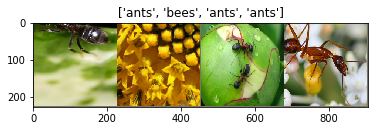

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### let's train our model
- with a schedule for learning rate; parameter `scheduler` in LR scheduler object from `torch.optim.lr_scheduler` 
- saving the best model; 

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### Visualizing the model
- a generic funciton to dispaly prediction for a few images

In [7]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

## Two different approaches for Transfer learnign:

### 1. FineTuning a Pretrained Deep Network (all of it)
- we are loading a pretrained model and reset final fully connected layer

#### Let's Train and Evaluate by method1

In [10]:
model_ft = models.resnet18(pretrained=True) # loading the pretrained resnet18 model
num_ftrs = model_ft.fc.in_features # getting the no of features in it's final fully connected layer #512

model_ft.fc = nn.Linear(num_ftrs, 2) # using a linear activation to map 512 to 2 layers # no of calss we need

if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss() # loass function we want to use

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /Users/vivek/.torch/models/resnet18-5c106cde.pth
100.0%


512

In [ ]:
## let's train the new model; with changed final layer
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.1257 Acc: 0.7910
val Loss: 0.0813 Acc: 0.8824

Epoch 1/24
----------
train Loss: 0.1083 Acc: 0.8074
val Loss: 0.0546 Acc: 0.9085

Epoch 2/24
----------
train Loss: 0.1887 Acc: 0.7377
val Loss: 0.0754 Acc: 0.9085

Epoch 3/24
----------
train Loss: 0.1315 Acc: 0.8074
val Loss: 0.0826 Acc: 0.9085

Epoch 4/24
----------
train Loss: 0.1737 Acc: 0.7582
val Loss: 0.1060 Acc: 0.8954

Epoch 5/24
----------
train Loss: 0.1352 Acc: 0.7582
val Loss: 0.0898 Acc: 0.8693

Epoch 6/24
----------
train Loss: 0.0914 Acc: 0.8607
val Loss: 0.0703 Acc: 0.8954

Epoch 7/24
----------
train Loss: 0.0569 Acc: 0.9139
val Loss: 0.0658 Acc: 0.8889

Epoch 8/24
----------
train Loss: 0.0631 Acc: 0.9180
val Loss: 0.0627 Acc: 0.9020

Epoch 9/24
----------
train Loss: 0.0648 Acc: 0.8975
val Loss: 0.0600 Acc: 0.9085

Epoch 10/24
----------
train Loss: 0.0756 Acc: 0.8648
val Loss: 0.0656 Acc: 0.9085

Epoch 11/24
----------
train Loss: 0.0632 Acc: 0.8893
val Loss: 0.0682 Acc: 0.9150

Ep

In [ ]:
visualize_model(model_ft)

### 2. ConvNet as fixed feature extractor
- In this metheology, we fix all the network parameters, except the final layer
- our training will only affect the final layer
- set `requires_grad=False` to freeze all the parameters so the gradients are not computed in `backward()`

#### Let's train and evaluate by method 2

In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True) # loading the trianed resnet18 model
for param in model_conv.parameters():
    param.requires_grad = False #freezing the parameters

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features # getting the no of features in last fc layer
model_conv.fc = nn.Linear(num_ftrs, 2) # mapping final layer outpu to 2 outputs

if use_gpu:
    model_conv = model_conv.cuda()

criterion = nn.CrossEntropyLoss() # our loss funciton

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9) #earlier model_ft.parameters()

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
# training will take half the time than the last time; as we don't need to compute gradient for most of the network
# we need to compute forward for all of the network
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()